<a href="https://colab.research.google.com/github/nabilneal/DataScience/blob/main/Data_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

In [ ]:
a#https://www.kaggle.com/jackogozaly/data-science-and-stem-salaries
df = pd.read_csv('Levels_Fyi_Salary_Data.csv')
df.head(10)

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education
0,7/14/2020 21:27,Samsung,L3,Human Resources,170000,"Mountain View, CA",8.0,1.0,10,141000,0.0,30000.0,Female,Race: White,7322,807.0,33165,0,0,0,0,0,0,1,0,0,0,White,NaN
1,2/4/2021 15:40,Illumina,1,Software Engineer,111000,"San Diego, TX",1.0,1.0,12,111000,0.0,0.0,NaN,Remote,11232,600.0,56576,0,0,0,0,0,0,0,0,0,0,NaN,NaN
2,11/2/2019 2:13,ExxonMobil,Senior Engineer,Mechanical Engineer,205000,"Houston, TX",10.0,10.0,--,195000,10000.0,0.0,Male,Masters,11109,618.0,17002,1,0,0,0,0,0,0,0,0,0,NaN,Master's Degree
3,6/17/2019 5:52,wework,4,Product Manager,140000,"Tel Aviv, TA, Israel",4.0,2.0,--,0,0.0,0.0,Male,NaN,15900,0.0,10424,0,0,0,0,0,0,0,0,0,0,NaN,NaN
4,1/25/2021 17:18,G-Research,L1,Software Engineer,100000,"London, EN, United Kingdom",0.0,0.0,--,100000,0.0,0.0,NaN,NaN,12008,0.0,55380,0,0,0,0,0,0,0,0,0,0,NaN,NaN
5,5/7/2021 11:49,ServiceNow,IC3,Software Engineer,199000,"Santa Clara, CA",6.0,1.0,--,154000,30000.0,15000.0,NaN,Title: Software Engineer,7434,807.0,68866,0,0,0,0,0,0,0,0,0,0,NaN,NaN
6,4/5/2019 17:47,Netflix,Senior Software Engineer,Software Engineer,393000,"Los Gatos, CA",8.0,0.0,--,375000,18750.0,0.0,Male,NaN,7277,807.0,7472,0,0,0,0,0,0,0,0,0,0,NaN,NaN
7,3/7/2021 21:43,IBM,Band 6,Management Consultant,75000,"Toronto, ON, Canada",0.0,0.0,#finance,75000,0.0,0.0,Male,"Title: Associate Consultant, Race: Asian, Acad...",1206,0.0,60503,0,1,0,0,0,1,0,0,0,0,Asian,Bachelor's Degree
8,6/3/2021 16:54,Google,L4,Business Analyst,197000,"San Francisco, CA",5.0,0.0,#ProductTeam,145000,30000.0,22000.0,Male,"Title: Business Intelligence Analyst, Academic...",7419,807.0,72270,1,0,0,0,0,0,0,0,0,0,NaN,Master's Degree
9,9/29/2020 7:10,Siemens,L3,Software Engineer,24000,"Lisbon, LI, Portugal",2.0,2.0,.NET,24000,0.0,0.0,NaN,NaN,6608,0.0,43169,0,0,0,0,0,0,0,0,0,0,NaN,NaN


In [ ]:
df.describe()

,totalyearlycompensation,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,bonus,cityid,dmaid,rowNumber,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic
count,6.264200e+04,62642.000000,62642.000000,6.264200e+04,6.264200e+04,62642.000000,62642.000000,62640.000000,62642.000000,62642.000000,62642.000000,62642.000000,62642.000000,62642.000000,62642.000000,62642.000000,62642.000000,62642.000000,62642.000000
mean,2.163004e+05,7.204135,2.702093,1.366873e+05,5.148608e+04,19334.746588,9856.201989,616.097222,41694.723732,0.245698,0.201223,0.028783,0.005108,0.005667,0.187925,0.128221,0.012835,0.011015,0.018039
std,1.380337e+05,5.840375,3.263656,6.136928e+04,8.187457e+04,26781.292040,6679.104563,289.843390,24488.865879,0.430504,0.400917,0.167196,0.071291,0.075067,0.390655,0.334338,0.112562,0.104373,0.133094
min,1.000000e+04,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.350000e+05,3.000000,0.000000,1.080000e+05,0.000000e+00,1000.000000,7369.000000,506.000000,20069.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.880000e+05,6.000000,2.000000,1.400000e+05,2.500000e+04,14000.000000,7839.000000,807.000000,42019.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.640000e+05,10.000000,4.000000,1.700000e+05,6.500000e+04,26000.000000,11521.000000,807.000000,63021.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.980000e+06,69.000000,69.000000,1.659870e+06,2.800000e+06,1000000.000000,47926.000000,881.000000,83875.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.dtypes

timestamp                   object
company                     object
level                       object
title                       object
totalyearlycompensation      int64
location                    object
yearsofexperience          float64
yearsatcompany             float64
tag                         object
basesalary                   int64
stockgrantvalue            float64
bonus                      float64
gender                      object
otherdetails                object
cityid                       int64
dmaid                      float64
rowNumber                    int64
Masters_Degree               int64
Bachelors_Degree             int64
Doctorate_Degree             int64
Highschool                   int64
Some_College                 int64
Race_Asian                   int64
Race_White                   int64
Race_Two_Or_More             int64
Race_Black                   int64
Race_Hispanic                int64
Race                        object
Education           

In [ ]:
def getBoxPlotFences(dt,showBoxPlot=False):
  Q1 = dt.quantile(0.25)
  Q3 = dt.quantile(0.75)
  IQR = Q3 - Q1

  Lower_Fence = Q1 - (1.5 * IQR)
  Upper_Fence = Q3 + (1.5 * IQR)

  if showBoxPlot:
    plt.figure(figsize=(20,5))
    bp =  plt.boxplot(dt,vert=False)

  return Lower_Fence,Upper_Fence

In [ ]:
#for all (String) , Strip + toLower
df_obj = df[['company','level','title','tag','otherdetails']]
df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
df[df_obj.columns] = df_obj.apply(lambda x: x.str.lower())

# Columns Cleaning

In [ ]:
#drop non-US based records (using location column)

In [ ]:
x = df[df['location'].str.match('^.+,(\s)*[a-zA-Z]{2}$') == False]['location']
x = x.index
print(f'to be dropped {len(x)}')
df = df.drop(index=x)
df.reset_index(drop=True, inplace=True)

to be dropped 9804


In [ ]:
#timestamp ; we need to extract (year,Month) from the column

In [ ]:
df['year'] = pd.DatetimeIndex(df['timestamp']).year
df['month'] = pd.DatetimeIndex(df['timestamp']).month

In [ ]:
#company; column is clean

In [ ]:
x = df['company'].str.match('[A-Za-z\s]+')
x = list(x[x == False].index)
print(len(x))
print(df.iloc[x]['company'].unique())

#sounds ok <column is clean>

54
['3m' '23andme' '7-eleven' '10x genomics' '8x8' '2u']


In [ ]:
#level ; we are not sure about the levels that are provided here, mostly they are not standard

In [ ]:
len(df['level'].unique())

2186

In [ ]:
#title; seems to be ok

In [ ]:
print(df['title'].unique())

# x = df.groupby('title').size()
# plt.figure(figsize=(20,10))
# plt.pie(x.values,labels=x.index)
# plt.tight_layout()

['human resources' 'software engineer' 'mechanical engineer'
 'business analyst' 'product designer' 'hardware engineer' 'marketing'
 'product manager' 'solution architect' 'technical program manager'
 'data scientist' 'management consultant' 'sales'
 'software engineering manager' 'recruiter']


In [ ]:
#totalyearlycompensation ; we have some outliers due to the fact that totalyearlycompensation is the sum of (salary,stock and bonus);

# in ML phase , we need to standardize the values , and remove the outliers if required
# for almost 10K records , we have wrong sum, so we need to re sum the value using (salary,stock and bonus)
# for almost 2K we have a value without corrosponding values in (salary,stock and bonus). we need to keep it and fill (salary,stock and bonus)
#                                                                                         based on the distribution for other records


#############
# Decision
#############
# in case when totalyearlycompensation != sum(salary,stock and bonus),  we have the following cases :

# when totalyearlycompensation > sum(salary,stock and bonus)
#   when totalyearlycompensation is available and  (salary,stock and bonus) are 0 ==> distribute over the 3 cols
#   when totalyearlycompensation is available and salary is 0 and (bonus or stock) are not 0 ==> fill difference into base salary
#   when totalyearlycompensation is available and salary is available ==> distribute the diff over (bonus and stock)

#when totalyearlycompensation < sum(salary,stock and bonus); re Sum totalyearlycompensation


In [ ]:
# when totalyearlycompensation < sum(salary,stock and bonus)
cond = df['totalyearlycompensation'] < (df['basesalary'] + df['stockgrantvalue']+df['bonus'])
df.loc[cond,'totalyearlycompensation'] = df['basesalary'] + df['stockgrantvalue']+df['bonus']

In [ ]:
#get (salary,stock and bonus) weights
weights = df[['basesalary','stockgrantvalue','bonus']].copy()
tot = df['basesalary'] + df['stockgrantvalue'] + df['bonus']

weights['basesalary_w'] = weights['basesalary'] / tot
weights['stockgrantvalue_w'] = weights['stockgrantvalue'] / tot
weights['bonus_w'] = weights['bonus'] / tot

weights = weights[['basesalary_w','stockgrantvalue_w','bonus_w']]
weights.fillna(0,inplace=True)
weights = weights.sum(axis=0)
weights = weights / weights.sum(axis=0)
weights.rename({'basesalary_w':'basesalary','stockgrantvalue_w':'stockgrantvalue','bonus_w':'bonus'},inplace=True)
weights

basesalary         0.727642
stockgrantvalue    0.184803
bonus              0.087555
dtype: float64

In [ ]:
# when totalyearlycompensation > sum(salary,stock and bonus)
cond = df['totalyearlycompensation'] > (df['basesalary'] + df['stockgrantvalue']+df['bonus'])

#   (1) when totalyearlycompensation is available and  (salary,stock and bonus) are 0 ==> distribute over the 3 cols
sub_cond = df['basesalary'] + df['stockgrantvalue'] + df['bonus'] == 0

df.loc[cond & sub_cond, 'basesalary'] = df['totalyearlycompensation'] * weights['basesalary']
df.loc[cond & sub_cond, 'stockgrantvalue'] = df['totalyearlycompensation'] * weights['stockgrantvalue']
df.loc[cond & sub_cond, 'bonus'] = df['totalyearlycompensation'] * weights['bonus']

#   (2) when totalyearlycompensation is available and salary is 0 and (bonus or stock) are not 0 ==> fill difference into base salary
sub_cond = (df['basesalary'] == 0) & (df['stockgrantvalue'] + df['bonus'] != 0)
df.loc[cond & sub_cond, 'basesalary'] = df['totalyearlycompensation'] - (df['stockgrantvalue'] + df['bonus'])

#   (3) when totalyearlycompensation is available and salary is available ==> distribute the diff over (bonus and stock)
sub_cond = (df['basesalary'] != 0)

sub_weights = weights[['stockgrantvalue','bonus']]
sub_weights = sub_weights /sub_weights.sum()

df.loc[cond & sub_cond, 'stockgrantvalue'] = (df['totalyearlycompensation'] - df['basesalary']) * sub_weights['stockgrantvalue']
df.loc[cond & sub_cond, 'bonus'] = (df['totalyearlycompensation'] - df['basesalary']) * sub_weights['bonus']


In [ ]:
#finally , round and convert to int , then Re-Sum totalyearlycompensation
df = df.astype({"basesalary": int, "stockgrantvalue": int,'bonus':int})
df['totalyearlycompensation'] = df['basesalary'] + df['stockgrantvalue'] + df['bonus']

column type is: int64
# of nulls: 0
min:11,000,max:4,979,999

avg: 236,585.03
Lower_Fence:-37,500.0,Upper_Fence:470,500.0
outliers # : 2,885


,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education,year,month


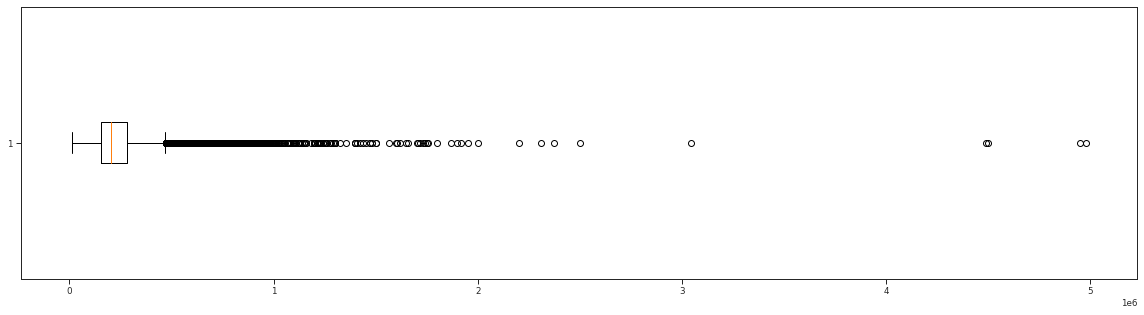

In [ ]:
print(f'column type is: {df.dtypes["totalyearlycompensation"]}')
Cnulls = df['totalyearlycompensation'].isnull()
print(f'# of nulls: {len(Cnulls[Cnulls == True])}')
print(f'min:{df["totalyearlycompensation"].min():,},max:{df["totalyearlycompensation"].max():,}')
print()

x = df['totalyearlycompensation']
print(f'avg: {x.mean():0,.2f}')


Q1 = x.quantile(0.25)
Q3 = x.quantile(0.75)
IQR = Q3 - Q1

Lower_Fence = Q1 - (1.5 * IQR)
Upper_Fence = Q3 + (1.5 * IQR)

print(f'Lower_Fence:{Lower_Fence:,},Upper_Fence:{Upper_Fence:,}')

l = x[x > Upper_Fence]
print(f'outliers # : {len(l):,}')


plt.figure(figsize=(20,5))
bp =  plt.boxplot(x,vert=False)


#resum wrong values
ix = df[(df['totalyearlycompensation'] != df['basesalary'] + df['stockgrantvalue'] + df['bonus']) & df['basesalary'] + df['stockgrantvalue'] + df['bonus'] != 0 ]
ix = ix.index
df.iloc[ix]

In [ ]:
#location; extract city,state values into two columns

In [ ]:
df['city'] = df['location'].str.extract(r'^(.+)(?=,)')
df['state'] = df['location'].str.extract(r'(?<=\,)(.+)')

df['city'] = df['city'].str.strip()
df['state'] = df['state'].str.strip()

In [ ]:
# for both yearsofexperience & yearsatcompany ; we need to fix mismatch

#update yearsofexperience to match atleast yearsatcompany


In [ ]:
df[(df['yearsofexperience'] > 0) &  (df['yearsatcompany'] == 0)]

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education,year,month,city,state
4,4/5/2019 17:47,netflix,senior software engineer,software engineer,393750,"Los Gatos, CA",8.0,0.0,--,375000,18750,0,Male,NaN,7277,807.0,7472,0,0,0,0,0,0,0,0,0,0,NaN,NaN,2019,4,Los Gatos,CA
5,6/3/2021 16:54,google,l4,business analyst,197000,"San Francisco, CA",5.0,0.0,#productteam,145000,30000,22000,Male,"title: business intelligence analyst, academic...",7419,807.0,72270,1,0,0,0,0,0,0,0,0,0,NaN,Master's Degree,2021,6,San Francisco,CA
16,4/18/2021 5:55,qualcomm,staff engineer,software engineer,197000,"San Diego, CA",4.0,0.0,5g,150000,27000,20000,NaN,title: systems engineer,7416,825.0,66261,0,0,0,0,0,0,0,0,0,0,NaN,NaN,2021,4,San Diego,CA
19,12/13/2020 13:22,samsung electronics america,tb6,solution architect,192000,"Plano, TX",7.0,0.0,5g,160000,0,32000,Male,"title: sr. systems engineer, race: asian, acad...",11204,623.0,51160,1,0,0,0,0,1,0,0,0,0,Asian,Master's Degree,2020,12,Plano,TX
24,4/6/2020 13:08,zillow,p3,data scientist,165000,"Seattle, WA",9.0,0.0,ab testing,135000,30000,0,Male,50k signing bonus over 2 years - masters,11527,819.0,26107,1,0,0,0,0,0,0,0,0,0,NaN,Master's Degree,2020,4,Seattle,WA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52787,6/18/2021 12:15,facebook,ic6,business analyst,235000,"Menlo Park, CA",10.0,0.0,whatsapp,190000,45000,0,Female,"title: ux qualitative researcher, race: hispan...",7300,807.0,74418,0,0,1,0,0,0,0,0,0,1,Hispanic,PhD,2021,6,Menlo Park,CA
52788,6/26/2021 8:21,amazon,l4,management consultant,150000,"Nashville, TN",25.0,0.0,whs,140000,10000,0,Male,"title: sr risk manager, race: white, academic ...",10919,659.0,75504,0,0,1,0,0,0,1,0,0,0,White,PhD,2021,6,Nashville,TN
52802,4/8/2020 18:45,microsoft,60,technical program manager,154000,"Redmond, WA",2.0,0.0,windows,115000,16000,23000,Female,10000 sign on,11521,819.0,26254,0,0,0,0,0,0,0,0,0,0,NaN,NaN,2020,4,Redmond,WA
52827,12/7/2020 10:12,deloitte,senior manager,management consultant,243000,"Detroit, MI",10.0,0.0,workday,190000,0,53000,Male,"title: senior manager, race: asian, academic l...",9052,505.0,50508,1,0,0,0,0,1,0,0,0,0,Asian,Master's Degree,2020,12,Detroit,MI


In [ ]:
df[df['yearsofexperience'] < df['yearsatcompany']]

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education,year,month,city,state
253,3/13/2020 14:54,intel,grade 5,hardware engineer,112000,"Hillsboro, OR",0.0,2.0,analog,97000,5000,10000,Male,masters,10500,820.0,24911,1,0,0,0,0,0,0,0,0,0,NaN,Master's Degree,2020,3,Hillsboro,OR
714,9/26/2019 16:19,microsoft,pm 2,product manager,100000,"San Francisco, CA",5.0,9.0,android,90000,10000,0,NaN,NaN,7419,807.0,15410,0,0,0,0,0,0,0,0,0,0,NaN,NaN,2019,9,San Francisco,CA
715,7/19/2019 16:40,expedia,l,product manager,132000,"Bellevue, WA",7.0,20.0,android,120000,0,12000,Female,NaN,11470,819.0,12120,0,0,0,0,0,0,0,0,0,0,NaN,NaN,2019,7,Bellevue,WA
764,2/13/2020 17:35,meijer,senior,software engineer,103000,"Grand Rapids, MI",4.0,6.0,android,103000,0,0,Male,NaN,9068,563.0,22434,0,0,0,0,0,0,0,0,0,0,NaN,NaN,2020,2,Grand Rapids,MI
789,4/6/2019 1:12,google,l4,software engineer,119999,"San Francisco, CA",2.0,3.0,android,87317,22176,10506,NaN,NaN,7419,807.0,7483,0,0,0,0,0,0,0,0,0,0,NaN,NaN,2019,4,San Francisco,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51566,7/14/2019 10:06,apple,ict3,software engineer,178000,"Sunnyvale, CA",5.0,12.0,web development (front-end),120000,50000,8000,Male,NaN,7472,807.0,11818,0,0,0,0,0,0,0,0,0,0,NaN,NaN,2019,7,Sunnyvale,CA
51585,9/12/2019 17:50,google,l3,software engineer,180000,"San Francisco, CA",0.0,1.0,web development (front-end),120000,40000,20000,Male,NaN,7419,807.0,14494,0,0,0,0,0,0,0,0,0,0,NaN,NaN,2019,9,San Francisco,CA
51877,8/22/2019 13:42,salesforce,associate member of technical staff,software engineer,206000,"San Francisco, CA",0.0,1.0,web development (front-end),133000,25000,48000,NaN,NaN,7419,807.0,13546,0,0,0,0,0,0,0,0,0,0,NaN,NaN,2019,8,San Francisco,CA
51901,1/18/2020 16:26,linkedin,associate,software engineer,210000,"San Francisco, CA",1.0,3.0,web development (front-end),140000,50000,20000,Male,NaN,7419,807.0,20485,0,0,0,0,0,0,0,0,0,0,NaN,NaN,2020,1,San Francisco,CA


In [ ]:
#yearsofexperience; some values are 0' , we need to figure out how to substitute these ! <seems to be Unknown , or missing>

In [ ]:
print(df['yearsofexperience'].unique())

df[df['yearsofexperience'] == 0.]

[ 8.    1.   10.    6.    5.    4.   20.    0.    3.    7.   12.   13.
 23.    9.   21.   26.   30.   15.    2.   11.   17.   22.   14.   18.
 16.   25.   19.   35.   38.    1.5  24.   31.   27.   28.   40.   37.
 42.   32.   36.   34.   29.   33.   41.   39.    2.5   7.5   5.5   0.58
  1.6   0.3   4.5  69.   45.    0.6   6.5   0.5   0.8   3.5   1.4   3.8
  8.5   6.75 10.5  11.5   0.25]


,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education,year,month,city,state
8,10/1/2020 12:31,blackrock,analyst,software engineer,115000,"New York, NY",0.0,0.0,2 year rotational program,105000,0,10000,Male,"an extra $10k sign on too, race: white, academ...",10182,501.0,43516,0,1,0,0,0,0,1,0,0,0,White,Bachelor's Degree,2020,10,New York,NY
14,7/13/2020 13:28,dish,pm,product manager,105000,"Denver, CO",0.0,0.0,5g,95000,0,10000,Male,race: white,7548,751.0,33046,0,0,0,0,0,0,1,0,0,0,White,NaN,2020,7,Denver,CO
15,11/3/2020 12:48,qualcomm,engineer,software engineer,123999,"Boulder, CO",0.0,0.0,5g,102000,14927,7072,Male,"$10k relocation bonus, title: software enginee...",7534,751.0,47544,1,0,0,0,0,1,0,0,0,0,Asian,Master's Degree,2020,11,Boulder,CO
41,8/9/2021 10:41,microsoft,59,marketing,106000,"Redmond, WA",0.0,0.0,ace,92000,5000,9000,Male,"title: product marketing manager, race: two or...",11521,819.0,82343,0,1,0,0,0,0,0,1,0,0,Two Or More,Bachelor's Degree,2021,8,Redmond,WA
53,1/22/2021 10:49,qualcomm,engineer,software engineer,149000,"San Diego, CA",0.0,0.0,adas,104000,20000,25000,Male,"title: engineer, race: asian, academic level: ...",7416,825.0,55003,1,0,0,0,0,1,0,0,0,0,Asian,Master's Degree,2021,1,San Diego,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52790,3/24/2021 21:41,microsoft,59,software engineer,174999,"Redmond, WA",0.0,0.0,window app,112000,42747,20252,Male,"title: software engineer, race: asian, academi...",11521,819.0,62785,0,1,0,0,0,1,0,0,0,0,Asian,Bachelor's Degree,2021,3,Redmond,WA
52794,10/1/2020 19:22,amd,l3,software engineer,80000,"Orlando, FL",0.0,0.0,windows,77000,0,3000,NaN,NaN,7776,534.0,43567,0,0,0,0,0,0,0,0,0,0,NaN,NaN,2020,10,Orlando,FL
52797,4/30/2019 20:11,microsoft,59,software engineer,119999,"Seattle, WA",0.0,0.0,windows,87317,22176,10506,Male,NaN,11527,819.0,8281,0,0,0,0,0,0,0,0,0,0,NaN,NaN,2019,4,Seattle,WA
52821,6/28/2021 14:08,qualcomm,senior engineer,hardware engineer,170000,"San Diego, CA",0.0,0.0,wireless r&d,140000,20000,10000,Male,"title: senior engineer, race: asian",7416,825.0,75748,0,0,0,0,0,1,0,0,0,0,Asian,NaN,2021,6,San Diego,CA


In [ ]:
#yearsatcompany ; the same problem as the previous

In [ ]:
print(df['yearsatcompany'].unique())
df[df['yearsatcompany'] == 0.]

[ 1.    10.     0.     7.     3.     2.     5.     8.    14.    16.
  6.     4.    20.     9.    11.    13.     2.5   15.    12.     5.5
  3.5    0.7    1.5    1.2    6.5    0.5    0.6   19.     0.25  17.
 24.     4.5    0.3   25.     0.85   0.2    0.8    0.1    2.4    1.9
  2.75  18.    27.    32.    34.     1.8   23.    22.    28.    21.
 26.     1.4   30.     0.75   2.9    4.4    3.3    2.6    1.666  1.7
  2.7    8.5   33.     2.3    1.75  15.5    0.4    7.5   40.     3.7
  1.6    4.75   4.8    0.58   0.33   4.2    2.8   69.     3.8    1.25
  1.1  ]


,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education,year,month,city,state
4,4/5/2019 17:47,netflix,senior software engineer,software engineer,393750,"Los Gatos, CA",8.0,0.0,--,375000,18750,0,Male,NaN,7277,807.0,7472,0,0,0,0,0,0,0,0,0,0,NaN,NaN,2019,4,Los Gatos,CA
5,6/3/2021 16:54,google,l4,business analyst,197000,"San Francisco, CA",5.0,0.0,#productteam,145000,30000,22000,Male,"title: business intelligence analyst, academic...",7419,807.0,72270,1,0,0,0,0,0,0,0,0,0,NaN,Master's Degree,2021,6,San Francisco,CA
8,10/1/2020 12:31,blackrock,analyst,software engineer,115000,"New York, NY",0.0,0.0,2 year rotational program,105000,0,10000,Male,"an extra $10k sign on too, race: white, academ...",10182,501.0,43516,0,1,0,0,0,0,1,0,0,0,White,Bachelor's Degree,2020,10,New York,NY
14,7/13/2020 13:28,dish,pm,product manager,105000,"Denver, CO",0.0,0.0,5g,95000,0,10000,Male,race: white,7548,751.0,33046,0,0,0,0,0,0,1,0,0,0,White,NaN,2020,7,Denver,CO
15,11/3/2020 12:48,qualcomm,engineer,software engineer,123999,"Boulder, CO",0.0,0.0,5g,102000,14927,7072,Male,"$10k relocation bonus, title: software enginee...",7534,751.0,47544,1,0,0,0,0,1,0,0,0,0,Asian,Master's Degree,2020,11,Boulder,CO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52802,4/8/2020 18:45,microsoft,60,technical program manager,154000,"Redmond, WA",2.0,0.0,windows,115000,16000,23000,Female,10000 sign on,11521,819.0,26254,0,0,0,0,0,0,0,0,0,0,NaN,NaN,2020,4,Redmond,WA
52821,6/28/2021 14:08,qualcomm,senior engineer,hardware engineer,170000,"San Diego, CA",0.0,0.0,wireless r&d,140000,20000,10000,Male,"title: senior engineer, race: asian",7416,825.0,75748,0,0,0,0,0,1,0,0,0,0,Asian,NaN,2021,6,San Diego,CA
52827,12/7/2020 10:12,deloitte,senior manager,management consultant,243000,"Detroit, MI",10.0,0.0,workday,190000,0,53000,Male,"title: senior manager, race: asian, academic l...",9052,505.0,50508,1,0,0,0,0,1,0,0,0,0,Asian,Master's Degree,2020,12,Detroit,MI
52829,6/25/2019 22:07,accenture,9,solution architect,104999,"Dallas, TX",2.0,0.0,workday implementation,76402,19404,9193,NaN,NaN,11039,623.0,11105,0,0,0,0,0,0,0,0,0,0,NaN,NaN,2019,6,Dallas,TX


In [ ]:
#tag ; it is like the level , it is hard to summarize these

In [ ]:
list(df['tag'].unique())

['10',
 '12',
 '--',
 '#productteam',
 '??',
 '2 year rotational program',
 '3.5 years',
 '3d',
 '3d artist',
 '3d visual merchandising',
 '5g',
 '5g networks',
 'a',
 'a& c',
 'èda',
 'ab testing',
 'abm',
 'access program',
 'accessibility',
 'accessories',
 'accessory',
 'accommodations',
 'account delivery management',
 'account executive',
 'account management',
 'account manager',
 'account strategist',
 'accounting',
 'ace',
 'acoustics',
 'actuarial',
 'ad',
 'ad measurement',
 'ad sales',
 'ad tech',
 'adas',
 'additive manufacturing',
 'ads',
 'ads & search sciences',
 'ads marketing',
 'ads ranking infra',
 'ads research',
 'adtech',
 'advertising',
 'advertising technology',
 'advisory',
 'advisory - strategy',
 'aem',
 'aerospace',
 'aerospace and defense',
 'aerospace consulting',
 'aerospace engineer',
 'aerospace mrb',
 'agile',
 'agile lead',
 'agile pm',
 'agile product management',
 'agile scrum master',
 'agile-devops delivery',
 'agribusiness',
 'ai',
 'ai / ml',
 

In [ ]:
#basesalary

column type is: int64
# of nulls: 0
min:9,000,max:1,659,870

count    5.283800e+04
mean     1.545005e+05
std      5.331328e+04
min      9.000000e+03
25%      1.230000e+05
50%      1.500000e+05
75%      1.760000e+05
max      1.659870e+06
Name: basesalary, dtype: float64
avg: 154,500.51
Lower_Fence:43,500.0,Upper_Fence:255,500.0
outliers # :L:70 + U:1420  =  1,490


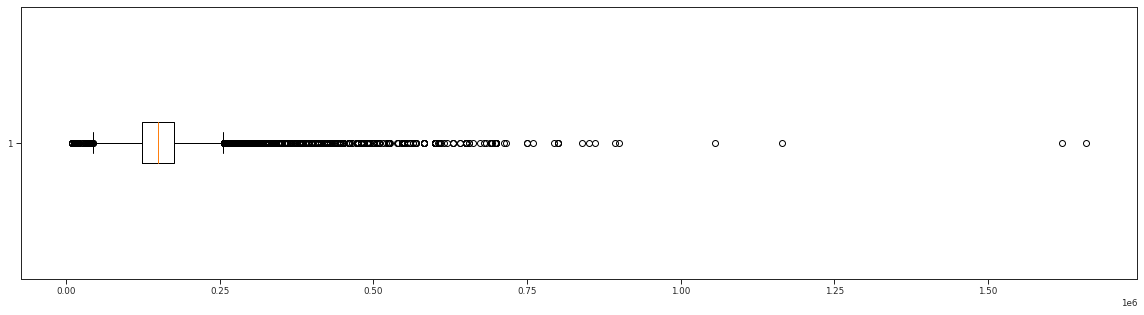

In [ ]:
print(f'column type is: {df.dtypes["basesalary"]}')
Cnulls = df['basesalary'].isnull()
print(f'# of nulls: {len(Cnulls[Cnulls == True])}')
print(f'min:{df["basesalary"].min():,},max:{df["basesalary"].max():,}')
print()
print(df['basesalary'].describe())
x = df['basesalary']
print(f'avg: {x.mean():0,.2f}')


Q1 = x.quantile(0.25)
Q3 = x.quantile(0.75)
IQR = Q3 - Q1

Lower_Fence = Q1 - (1.5 * IQR)
Upper_Fence = Q3 + (1.5 * IQR)

print(f'Lower_Fence:{Lower_Fence:,},Upper_Fence:{Upper_Fence:,}')

uV = x[x > Upper_Fence]
lV =  x[x < Lower_Fence]
print(f'outliers # :L:{len(lV)} + U:{len(uV)}  =  {len(uV)+len(lV):,}')


plt.figure(figsize=(20,5))
bp =  plt.boxplot(x,vert=False)



In [ ]:
#stockgrantvalue

column type is: int64
# of nulls: 0
min:0,max:3,121,231

count    5.283800e+04
mean     5.967641e+04
std      9.082096e+04
min      0.000000e+00
25%      6.000000e+03
50%      3.200000e+04
75%      7.500000e+04
max      3.121231e+06
Name: stockgrantvalue, dtype: float64
avg: 59,676.41
Lower_Fence:-97,500.0,Upper_Fence:178,500.0
outliers # :L:0 + U:3888  =  3,888


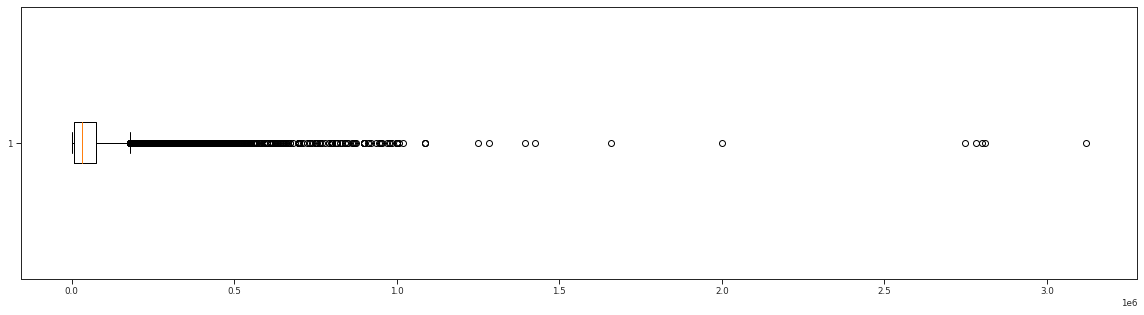

In [ ]:
print(f'column type is: {df.dtypes["stockgrantvalue"]}')
Cnulls = df['stockgrantvalue'].isnull()
print(f'# of nulls: {len(Cnulls[Cnulls == True])}')
print(f'min:{df["stockgrantvalue"].min():,},max:{df["stockgrantvalue"].max():,}')
print()
print(df['stockgrantvalue'].describe())
x = df['stockgrantvalue']
print(f'avg: {x.mean():0,.2f}')


Q1 = x.quantile(0.25)
Q3 = x.quantile(0.75)
IQR = Q3 - Q1

Lower_Fence = Q1 - (1.5 * IQR)
Upper_Fence = Q3 + (1.5 * IQR)

print(f'Lower_Fence:{Lower_Fence:,},Upper_Fence:{Upper_Fence:,}')

uV = x[x > Upper_Fence]
lV =  x[x < Lower_Fence]
print(f'outliers # :L:{len(lV)} + U:{len(uV)}  =  {len(uV)+len(lV):,}')


plt.figure(figsize=(20,5))
bp =  plt.boxplot(x,vert=False)



In [ ]:
#bonus

column type is: int64
# of nulls: 0
min:0,max:1,478,768

count    5.283800e+04
mean     2.240812e+04
std      3.175847e+04
min      0.000000e+00
25%      5.000000e+03
50%      1.600000e+04
75%      3.000000e+04
max      1.478768e+06
Name: bonus, dtype: float64
avg: 22,408.12
Lower_Fence:-32,500.0,Upper_Fence:67,500.0
outliers # :L:0 + U:2382  =  2,382


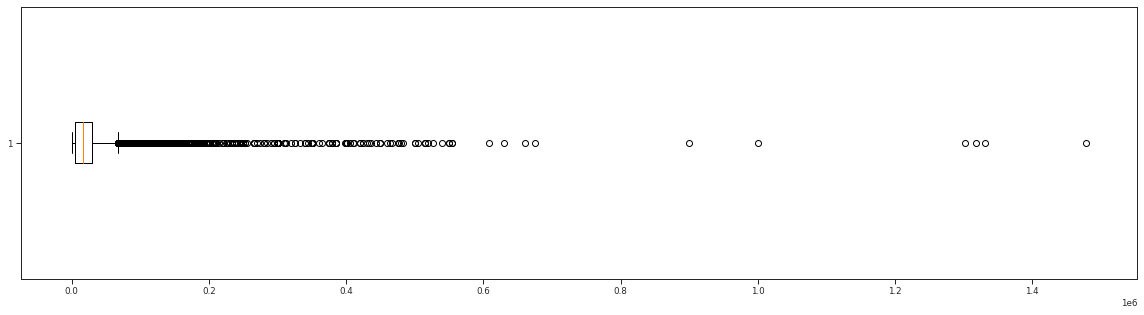

In [ ]:
print(f'column type is: {df.dtypes["bonus"]}')
Cnulls = df['bonus'].isnull()
print(f'# of nulls: {len(Cnulls[Cnulls == True])}')
print(f'min:{df["bonus"].min():,},max:{df["bonus"].max():,}')
print()
print(df['bonus'].describe())
x = df['bonus']
print(f'avg: {x.mean():0,.2f}')


Q1 = x.quantile(0.25)
Q3 = x.quantile(0.75)
IQR = Q3 - Q1

Lower_Fence = Q1 - (1.5 * IQR)
Upper_Fence = Q3 + (1.5 * IQR)

print(f'Lower_Fence:{Lower_Fence:,},Upper_Fence:{Upper_Fence:,}')

uV = x[x > Upper_Fence]
lV =  x[x < Lower_Fence]
print(f'outliers # :L:{len(lV)} + U:{len(uV)}  =  {len(uV)+len(lV):,}')


plt.figure(figsize=(20,5))
bp =  plt.boxplot(x,vert=False)



In [ ]:
#gender

([<matplotlib.patches.Wedge at 0x7ff94fa44a90>,
 [Text(1.024157842027648, 0.40137353501853024, 'Female'),
  Text(-0.8662353343728877, 0.6779648556406825, 'Male'),
  Text(-0.5115471891080238, -0.9738169608893039, 'Other'),
  Text(-0.49123130588893343, -0.9842214202681494, 'Title: Senior Software Engineer'),
  Text(0.5786666258977415, -0.935491815074896, 'nan')])

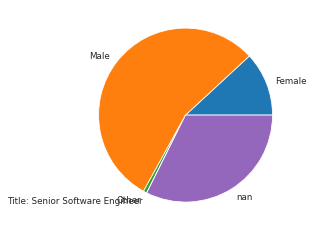

In [ ]:
x = df.groupby('gender',dropna=False).size()
plt.pie(x.values,labels=x.index)

([<matplotlib.patches.Wedge at 0x7ff94dd728d0>,
 [Text(1.024157842027648, 0.40137353501853024, 'Female'),
  Text(-0.8662353343728877, 0.6779648556406825, 'Male'),
  Text(-0.5115471891080238, -0.9738169608893039, 'Other'),
  Text(0.5786109994546479, -0.9355262216047681, 'Unknown')])

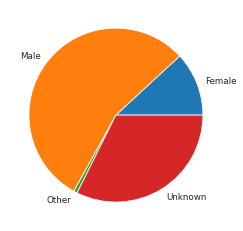

In [ ]:
cond = (df['gender'] == 'Male') | (df['gender'] == 'Female') | (df['gender'] == 'Other')
x = df['gender'].where(cond,'Unknown')
x.name = 'gender'

df.update(x)

x = df.groupby('gender',dropna=False).size()
plt.pie(x.values,labels=x.index)

In [ ]:
#otherdetails; a lot of unstarded values

In [ ]:
list(df['otherdetails'].unique())

['race: white',
 'remote',
 'masters',
 'title: software engineer',
 nan,
 'title: business intelligence analyst, academic level: master’s degree',
 'an extra $10k sign on too, race: white, academic level: bachelor’s degree',
 'race: asian, academic level: bachelor’s degree',
 'title: senior designer, race: white, academic level: bachelor’s degree',
 '$10k relocation bonus, title: software engineer, race: asian, academic level: master’s degree',
 'title: systems engineer',
 'title: staff engineer, race: asian, academic level: master’s degree',
 'title: modem sw',
 'title: sr. systems engineer, race: asian, academic level: master’s degree',
 'race: asian, academic level: master’s degree',
 'phd',
 'title: manager, academic level: master’s degree',
 'academic level: master’s degree',
 '50k signing bonus over 2 years - masters',
 'title: financial analyst, race: white, academic level: bachelor’s degree',
 'remote, race: white, academic level: master’s degree',
 'title: firmware engineer, 

In [ ]:
#cityid	dmaid	rowNumber - we dont need these

In [ ]:
#education; seems to be ok ; we need to take a look at nulls

Education
Bachelor's Degree     9473
Highschool             207
Master's Degree      12901
PhD                   1546
Some College           295
NaN                  28416
dtype: int64


([<matplotlib.patches.Wedge at 0x7ff94e498a10>,
 [Text(0.9300844640967199, 0.5873183886495619, "Bachelor's Degree"),
  Text(0.4605717817994649, 0.9989362511241977, 'Highschool'),
  Text(-0.3744460883227421, 1.0343065923312087, "Master's Degree"),
  Text(-1.027743354428359, 0.3921015141877732, 'PhD'),
  Text(-1.0644264567196609, 0.2774821043513042, 'Some College'),
  Text(-0.13030271983406427, -1.0922550989598747, 'nan')])

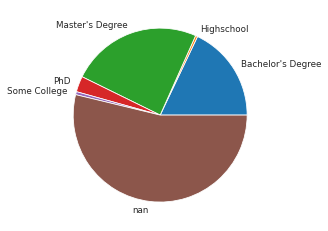

In [ ]:
x = df.groupby('Education',dropna=False).size()
print(x)
plt.pie(x.values,labels=x.index)

In [ ]:
df['Education'] = df['Education'].fillna('UnKnown')

In [ ]:
df[df['Education'].isnull() & (df['Masters_Degree']+ df['Bachelors_Degree']	+df['Doctorate_Degree'] +df['Highschool']	+df['Some_College'] > 0)]

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education,year,month,city,state


In [ ]:
#Race; seems to be ok

Race
Asian           8953
Black            620
Hispanic         957
Two Or More      673
White           6390
NaN            35245
dtype: int64


([<matplotlib.patches.Wedge at 0x7ff94e582490>,
 [Text(0.9477955832762035, 0.5582862458650771, 'Asian'),
  Text(0.49748304885787503, 0.981076253967587, 'Black'),
  Text(0.4034430976845206, 1.023344354032756, 'Hispanic'),
  Text(0.30252764668048815, 1.0575807406500772, 'Two Or More'),
  Text(-0.15494537626023314, 1.0890325662603368, 'White'),
  Text(-0.5511135953746243, -0.951984141145878, 'nan')])

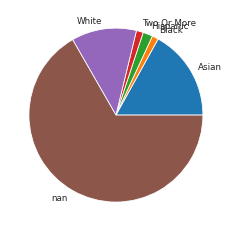

In [ ]:
x = df.groupby('Race',dropna=False).size()
print(x)
plt.pie(x.values,labels=x.index)

In [ ]:
df['Race'] = df['Race'].fillna('UnKnown')

In [ ]:
df[df['Race'].isnull() & (df['Race_Asian']+ df['Race_White']	+df['Race_Two_Or_More'] +df['Race_Black']	+df['Race_Hispanic'] > 0)]

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education,year,month,city,state


In [ ]:
len(list(df['state'].unique()))

49

In [ ]:
df['state'].unique()

array(['CA', 'TX', 'NY', 'WA', 'VA', 'CO', 'MA', 'MI', 'OH', 'IL', 'NJ',
       'GA', 'DC', 'CT', 'PA', 'MO', 'NE', 'AZ', 'NC', 'OR', 'WI', 'FL',
       'IA', 'IN', 'KY', 'ID', 'MN', 'DE', 'UT', 'NH', 'TN', 'VT', 'MD',
       'LA', 'SC', 'AL', 'AR', 'ND', 'RI', 'KS', 'MT', 'NV', 'ME', 'OK',
       'MS', 'NM', 'HI', 'WY', 'WV'], dtype=object)

Answering

# Q1: What are the base salary trends in the top 5 states by race?
### Execlude (UnKnown Race) and filter out the outliers
### Execlude any state with less than 5 records


Lower_Fence: 43500.0,Upper_Fence:247500.0


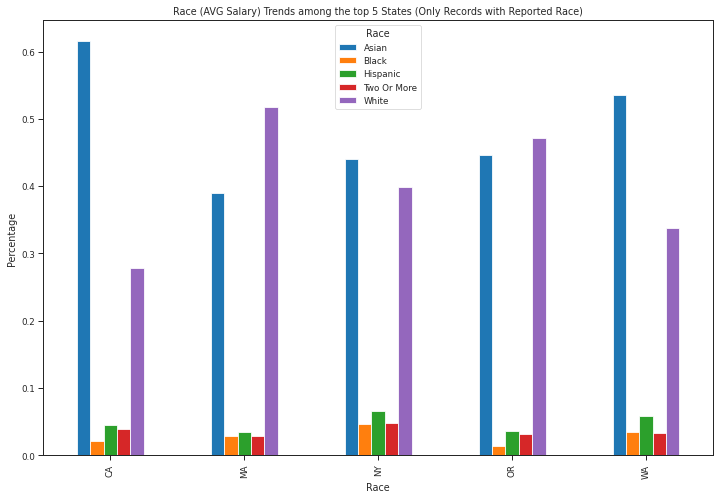

In [ ]:

cond_Unknow = df['Race'] != 'UnKnown'

res = df.loc[cond_Unknow,['state','Race','basesalary']]

Lower_Fence,Upper_Fence = getBoxPlotFences(res['basesalary'].copy())
print(f'Lower_Fence: {Lower_Fence},Upper_Fence:{Upper_Fence}')

res = res.copy()
res.loc[res['basesalary'] > Upper_Fence,'basesalary'] = Upper_Fence
res.loc[res['basesalary'] < Lower_Fence,'basesalary'] = Lower_Fence


#get valid states with >= 5 records
ValidStates = res.groupby('state').size()
ValidStates = ValidStates[ValidStates >= 5]
ValidStates = list(ValidStates.index)

cond_validStates = res['state'].apply(lambda x:x in ValidStates)
res = res[cond_validStates]

#get top 5 states bases on the avg of basesalary
top5_df = res.groupby('state').mean('basesalary').sort_values('basesalary',ascending=False)['basesalary'].head(5)
top5 = list(top5_df.index)

#set filters to get the top 5 states & to execlude 'UnKnown' Race (it does not make sense to be presented)
cond = res['state'].apply(lambda x:x in top5)

#get the results based on the filters
res = res.loc[cond,['state','Race']]
res = res.groupby(['state','Race']).size()
res = res / res.groupby('state').sum() # get percentage of each race

#Convert to DF
res_df = res.to_frame(name='cnt')

#Pivot DF
res_df = res_df.pivot_table('cnt',['state'],'Race')
res_df.reset_index(inplace=True)

#Plot
res_df.plot(x='state',y=list(res_df.columns).remove('state'),kind='bar',figsize=(12,8),
            title='Race (AVG Salary) Trends among the top 5 States (Only Records with Reported Race)',xlabel='Race',ylabel='Percentage')

# Q2: What are the trends in base salaries (avg) over months across the years (group by YYYY-MM) by (Experience Level)?


Lower_Fence: 43500.0,Upper_Fence:255500.0


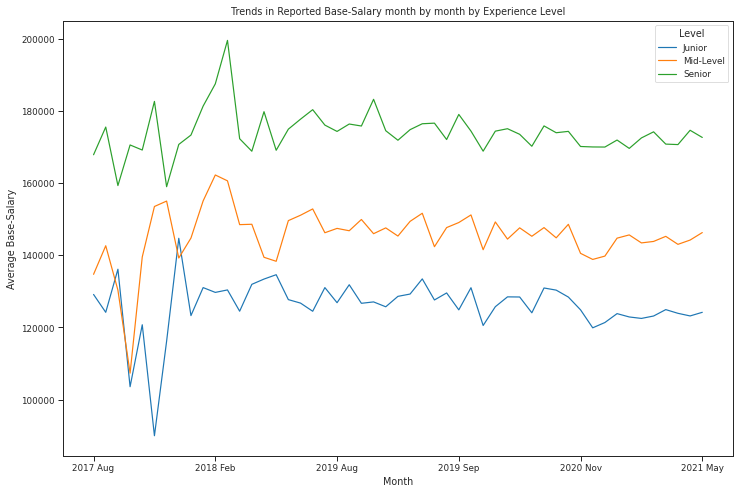

In [ ]:

res = df.loc[:,['year','month','yearsofexperience','basesalary']]
#fliter outliers
Lower_Fence,Upper_Fence = getBoxPlotFences(res['basesalary'].copy())
print(f'Lower_Fence: {Lower_Fence},Upper_Fence:{Upper_Fence}')

res = res.copy()
res.loc[res['basesalary'] > Upper_Fence,'basesalary'] = Upper_Fence
res.loc[res['basesalary'] < Lower_Fence,'basesalary'] = Lower_Fence

bins = [0,3,5,np.inf]
names = ['Junior','Mid-Level','Senior']
res['yearsofexperience'] = pd.cut(res['yearsofexperience'], bins, labels=names)
res.rename(columns = {'yearsofexperience':'Level'},inplace=True)

res = res.groupby(['year','month','Level']).mean('basesalary')['basesalary']

df_res = res.to_frame(name='average basesalary').reset_index()
df_res['month_abbr'] = df_res['month'].apply(lambda x: calendar.month_abbr[x])

df_res['label'] = df_res['year'].astype(str) +' '+ df_res['month_abbr']
df_res = df_res.drop(['year','month','month_abbr'],axis=1)

# Pivot DF
df_res = df_res.pivot_table('average basesalary',['label'],'Level')
df_res.columns = df_res.columns.astype(str)
df_res.reset_index(inplace=True)

#Plot
df_res.plot(x='label',y=list(df_res.columns).remove('label'),kind='line',figsize=(12,8),
            title='Trends in Reported Base-Salary month by month by Experience Level',xlabel='Month',ylabel='Average Base-Salary')


# Q3 :What are the trends in base salaries (avg) among genders across the past period (group by YYYY-MM)?
### execlude Unknown / Un-Reported Gender

In [ ]:
cond = df['gender'] != 'Unknown' # execlude Unknown or Un Reported Gender
cond_Other = df['gender'] != 'Other' # execlude Unknown or Un Reported Gender

res = df.loc[cond & cond_Other]

#filter out outliers
Lower_Fence,Upper_Fence = getBoxPlotFences(res['basesalary'].copy())
print(f'Lower_Fence: {Lower_Fence},Upper_Fence:{Upper_Fence}')

res = res.copy()
res.loc[res['basesalary'] > Upper_Fence,'basesalary'] = Upper_Fence
res.loc[res['basesalary'] < Lower_Fence,'basesalary'] = Lower_Fence


res = res.groupby(['year','month','gender']).mean('basesalary')['basesalary']
df_res = res.to_frame(name = 'average basesalary')
df_res.reset_index(inplace=True)

df_res
# #get label (YY-MM)
# df_res['month_abbr'] = df_res['month'].apply(lambda x: calendar.month_abbr[x])
# df_res['label'] = df_res['year'].astype(str) +' '+ df_res['month_abbr']
# df_res = df_res.drop(['year','month','month_abbr'],axis=1)

# #Prepaid the results
# df_res = df_res.pivot_table('average basesalary','label','gender')
# df_res.reset_index(inplace=True)

# #Plot
# df_res.plot(x='label',y=list(df_res.columns).remove('label'),kind='line',figsize=(12,5)
#             ,title='Trends in Reported Base-Salary among Reported Genders month by month',xlabel= 'Month',ylabel='Average Base-Salary')

Lower_Fence: 42774.5,Upper_Fence:254042.5


,year,month,gender,average basesalary
0,2018,4,Female,150500.000000
1,2018,4,Male,151844.779661
2,2018,5,Female,131730.125000
3,2018,5,Male,155145.561688
4,2018,6,Female,123643.708333
...,...,...,...,...
74,2021,6,Male,148787.272171
75,2021,7,Female,145080.485714
76,2021,7,Male,150568.637436
77,2021,8,Female,144955.308219


# Q4: What is the distribution of levels (y of exp) among the top 10 companies?


Lower_Fence: 44000.0,Upper_Fence:260000.0


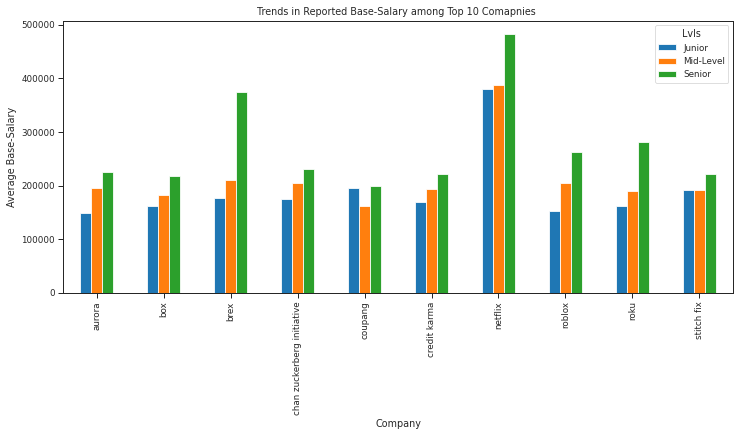

In [ ]:
validComp = df.groupby('company').size()
validComp = validComp[validComp >= 10]
validComp = list(validComp.index)
cond_validComp = df['company'].apply(lambda x:x in validComp)

res = df[cond_validComp]

#filter out the outliers
Lower_Fence,Upper_Fence = getBoxPlotFences(res['basesalary'].copy())
print(f'Lower_Fence: {Lower_Fence},Upper_Fence:{Upper_Fence}')

res = res.copy()
res.loc[res['basesalary'] > Upper_Fence,'basesalary'] = Upper_Fence
res.loc[res['basesalary'] < Lower_Fence,'basesalary'] = Lower_Fence


top10 = res.groupby('company').mean('basesalary')['basesalary'].sort_values(ascending=False).head(10)
top10Comp = list(top10.index)

cond = df['company'].apply(lambda x:x in top10Comp)

res = df[cond].copy()
bins = [0,3,5,np.inf]
names = ['Junior','Mid-Level','Senior']

res['Lvls'] = pd.cut(res['yearsofexperience'], bins, labels=names)
res = res.groupby(['company','Lvls']).mean('basesalary')['basesalary']
# print(res)
res_df = res.to_frame(name='average basesalary')
res_df.reset_index(inplace=True)

res_df = res_df.pivot_table('average basesalary','company','Lvls')
res_df.columns = res_df.columns.astype(str)
res_df.reset_index(inplace=True)

res_df.plot(x='company',y=list(res_df.columns).remove('company'),kind='bar',figsize=(12,5)
            ,title='Trends in Reported Base-Salary among Top 10 Comapnies ',xlabel= 'Company',ylabel='Average Base-Salary')

# Q5: What are the Top companies with racial diversity (based on distribution of each race)? (Exclude others)
### the idea is to try to find the expected weight of each race (execlude UnKnown), then find the extra weight of each company
#### sort ascending to get the companies with lowest extra weights for races


5


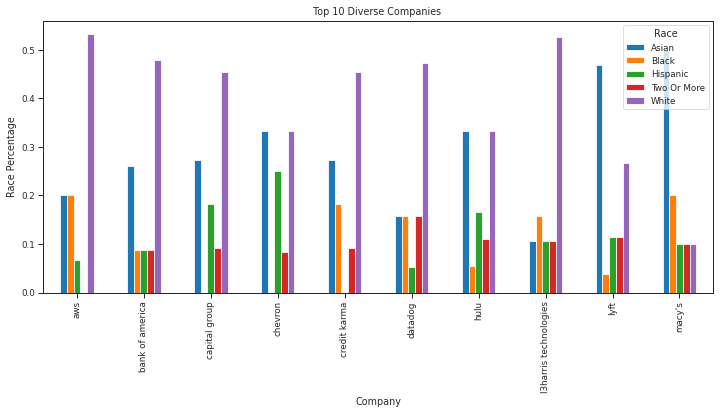

In [ ]:

cond_race = df['Race'] != 'UnKnown'
# cond_2orM = df['Race'] != 'Two Or More'


res = df[cond_race]

NofRaces = len(list(res['Race'].unique()))
print(NofRaces)


#get only companies with atleast 10 records <remove unwanted records>
validComp = res.groupby('company').size()
validComp = validComp[validComp >= 10]
validComp = list(validComp.index)


cond_validComp = res['company'].apply(lambda x:x in validComp)

res = res[cond_validComp].groupby(['company','Race']).size()
res = (res / res.groupby('company').sum()) - (1/NofRaces)
res_df = res.to_frame('diff')
res_df.reset_index(inplace=True)

res_df = res_df.loc[res_df['diff'] >= 0,['company','diff']]
res_df = res_df.groupby('company').sum()['diff']
res_df = res_df.sort_values()

top10 = res_df.head(10)
top10 = list(top10.index)



cond = df['company'].apply(lambda x:x in top10)
res = df[cond & cond_race][['company','Race']].groupby(['company','Race']).size()
res = res / res.groupby('company').sum()
res_df = res.to_frame(name = 'percentage')
res_df.reset_index(inplace=True)

res_df = res_df.pivot_table('percentage','company','Race')
res_df.reset_index(inplace=True)

res_df.plot(x='company',y=list(res_df.columns).remove('company'),kind='bar',figsize=(12,5)
            ,title='Top 10 Diverse Companies ',xlabel= 'Company',ylabel='Race Percentage')

# Q6 : What are the top 5 states based on base salaries (avg)?  


In [ ]:
#Get rid of outliers in total yearly compensation and base salary column
x = df['totalyearlycompensation']
Lower_Fence, Upper_Fence = getBoxPlotFences(x)
df1 = df[(x<=Upper_Fence) & (x>Lower_Fence)]

x1 = df1['basesalary']
Lower_Fence,Upper_Fence = getBoxPlotFences(x1)
df1 = df1[(x1<=Upper_Fence) & (x1>Lower_Fence)]

ValidStates = df1.groupby('state').size()
ValidStates = ValidStates[ValidStates >= 5]
ValidStates = list(ValidStates.index)
cond_validStates = df1['state'].apply(lambda x:x in ValidStates)
df1 = df1[cond_validStates]

Text(0.5, 0, 'Average Base Salary')

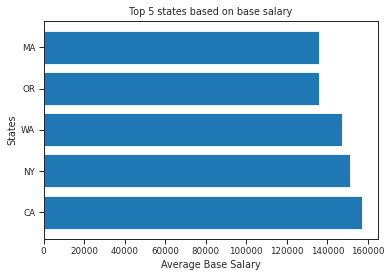

In [ ]:
avg_sal = df1.groupby("state").mean()["basesalary"]
avg_sal_5 = avg_sal.sort_values(ascending=False).head(5)
avg_sal_5

plt.barh(avg_sal_5.index, avg_sal_5.values)
plt.title('Top 5 states based on base salary')
plt.ylabel('States')
plt.xlabel('Average Base Salary')

# Q7 : What is the average base salary by degree level? (Exclude others)




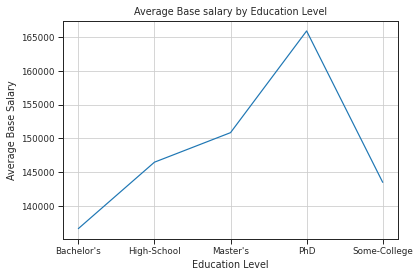

In [ ]:
avg_sal_edu = df1.groupby("Education").mean()["basesalary"]
# i = avg_sal_5[avg_sal_5["Education"] != "UnKnown"]
Edu_comp = avg_sal_edu[avg_sal_edu.index != "UnKnown"]
Edu_comp
plt.plot(Edu_comp.index, Edu_comp.values)
plt.title('Average Base salary by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Average Base Salary')
plt.xticks([0.0,1.0,2.0,3.0,4.0],["Bachelor's",'High-School',"Master's","PhD", "Some-College"])
plt.grid(True)


(-1.1184697294213544,
 1.1008795708592445,
 -1.123247715516506,
 1.1235222446374262)

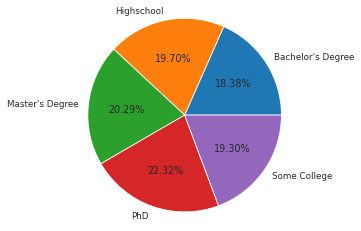

In [ ]:
plt.pie(Edu_comp, labels = Edu_comp.index, autopct = "%0.2f%%" )
plt.axis("equal")


# Q8 : What is the top title for the top 5 states based on salary (avg)?



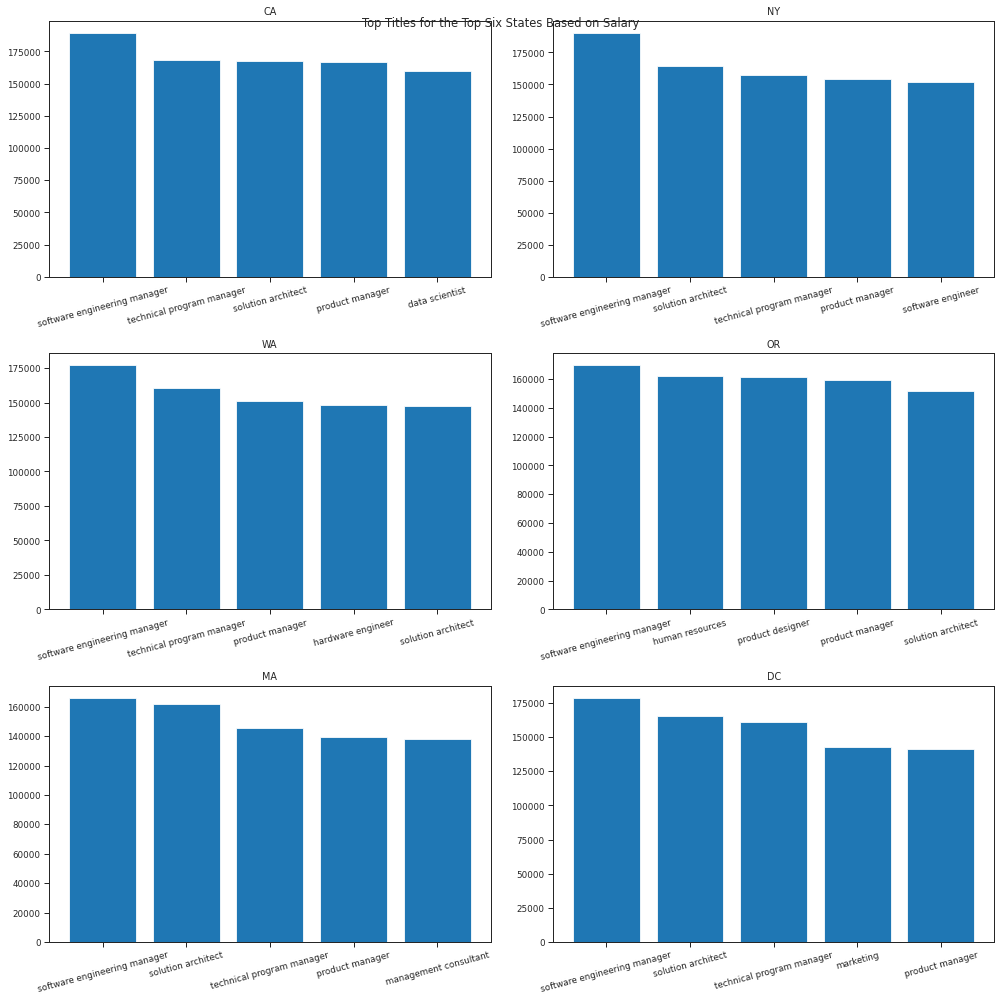

In [ ]:
top_state = (df1.groupby("state").mean()["basesalary"]).sort_values(ascending = False).head(6)
top_state = list(top_state.index)
top_state

fig = plt.figure(figsize=(14,14))

fig.suptitle("Top Titles for the Top Six States Based on Salary")

axes1 = fig.add_subplot(321)
axes2 = fig.add_subplot(322)
axes3 = fig.add_subplot(323)
axes4 = fig.add_subplot(324)
axes5 = fig.add_subplot(325)
axes6 = fig.add_subplot(326)
count = 1

for i in top_state:
    level_state = df1[df1["state"] == i]
    level_state = level_state.groupby("title").mean()["basesalary"].sort_values(ascending = False).head(5)
    level_state
    if count == 1:
        axes1.bar(level_state.index,level_state.values)
        for tick in axes1.get_xticklabels():
            tick.set_rotation(15)
    elif count == 2:
        axes2.bar(level_state.index,level_state.values)
        for tick in axes2.get_xticklabels():
            tick.set_rotation(15)
    elif count == 3:
        axes3.bar(level_state.index,level_state.values)
        for tick in axes3.get_xticklabels():
            tick.set_rotation(15)
    elif count == 4:
        axes4.bar(level_state.index,level_state.values)
        for tick in axes4.get_xticklabels():
            tick.set_rotation(15)
    elif count == 5:
        axes5.bar(level_state.index,level_state.values)
        for tick in axes5.get_xticklabels():
            tick.set_rotation(15)
    elif count == 6:
        axes6.bar(level_state.index,level_state.values)
        for tick in axes6.get_xticklabels():
            tick.set_rotation(15)
    count+=1



axes1.set_title(top_state[0])
axes2.set_title(top_state[1])
axes3.set_title(top_state[2])
axes4.set_title(top_state[3])
axes5.set_title(top_state[4])
axes6.set_title(top_state[5])

fig.tight_layout()

# Q9 : What is the top 10 companies for each title based on salaries (avg)?






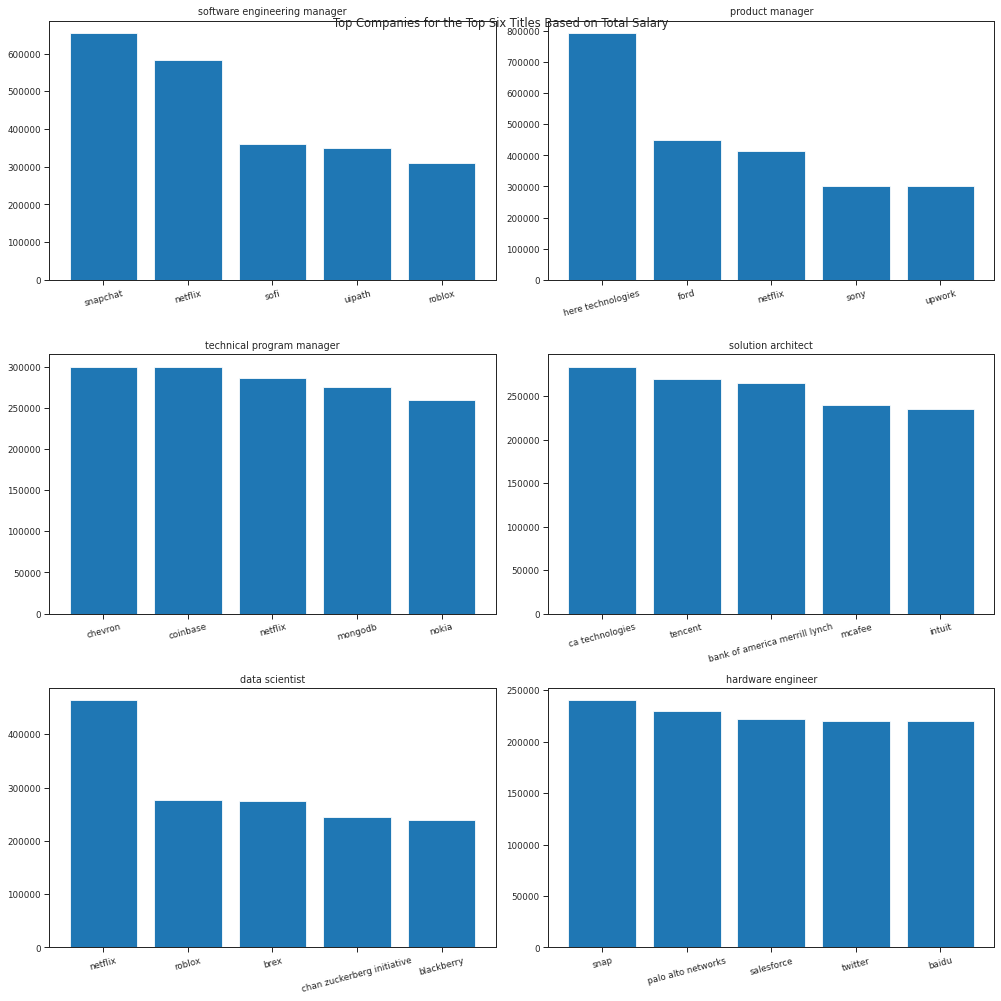

In [ ]:
top_titles = (df.groupby("title").mean()["basesalary"]).sort_values(ascending = False).head(6)
top_titles = list(top_titles.index)
top_titles

fig = plt.figure(figsize=(14,14))

fig.suptitle("Top Companies for the Top Six Titles Based on Total Salary")
# fig.tight_layout()
axes1 = fig.add_subplot(321)
axes2 = fig.add_subplot(322)
axes3 = fig.add_subplot(323)
axes4 = fig.add_subplot(324)
axes5 = fig.add_subplot(325)
axes6 = fig.add_subplot(326)
count = 1

for i in top_titles:
    company_title = df[df["title"] == i]
    company_title = company_title.groupby("company").mean()["basesalary"].sort_values(ascending = False).head(5)
    # print(company_title)
    if count == 1:
        axes1.bar(company_title.index,company_title.values)
        for tick in axes1.get_xticklabels():
            tick.set_rotation(15)
    elif count == 2:
        axes2.bar(company_title.index,company_title.values)
        for tick in axes2.get_xticklabels():
            tick.set_rotation(15)
    elif count == 3:
        axes3.bar(company_title.index,company_title.values)
        for tick in axes3.get_xticklabels():
            tick.set_rotation(15)
    elif count == 4:
        axes4.bar(company_title.index,company_title.values)
        for tick in axes4.get_xticklabels():
            tick.set_rotation(15)
    elif count == 5:
        axes5.bar(company_title.index,company_title.values)
        for tick in axes5.get_xticklabels():
            tick.set_rotation(15)
    elif count == 6:
        axes6.bar(company_title.index,company_title.values)
        for tick in axes6.get_xticklabels():
            tick.set_rotation(15)
    count+=1



axes1.set_title(top_titles[0])
axes2.set_title(top_titles[1])
axes3.set_title(top_titles[2])
axes4.set_title(top_titles[3])
axes5.set_title(top_titles[4])
axes6.set_title(top_titles[5])

fig.tight_layout()

# Q10 : What is the relation between years of experience and the avg total year comp.?






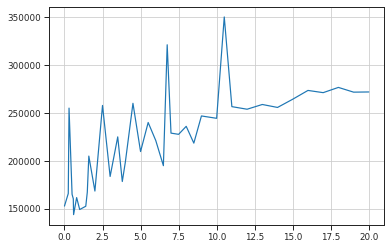

In [ ]:
#Get rid of outliers in years of experience column
x1 = df1['yearsofexperience']
Lower_Fence, Upper_Fence = getBoxPlotFences(x1)

df1 = df1[(x1<=Upper_Fence) & (x1>Lower_Fence)]

#getting the average total yearly compensation to get the trend in years of experience
avg_sal_exp = (df1.groupby("yearsofexperience").mean()["totalyearlycompensation"])
avg_sal_exp

#show the plot to understand the trend
plt.plot(avg_sal_exp.index,avg_sal_exp.values)

# to view the grid in the plot.
plt.grid(True)

Question 11

What are the top 5 states based on base salaries (avg) for each gender?

In [ ]:
# filtered_gender = df[(df['gender'] != "Unknown") & (df['gender'] != "Other")]
#Get rid of outliers in total yearly compensation and base salary column
p = df['totalyearlycompensation']
Lower_Fence, Upper_Fence = getBoxPlotFences(p)
df_fil = df[(p<=Upper_Fence) & (p>Lower_Fence)]

p1 = df_fil['basesalary']
Lower_Fence,Upper_Fence = getBoxPlotFences(p1)
df_fil_basesalary = df_fil[(p1<=Upper_Fence) & (p1>Lower_Fence)]

filtered_gender = df_fil_basesalary[(df_fil_basesalary['gender'] != "Unknown") & (df_fil_basesalary['gender'] != "Other")]

# Getting the average base salary for each state based on genders:
mean_salary_by_gender = filtered_gender.groupby(["state", 'gender'], as_index=False).basesalary.mean()

# Sorting the values in the decending order based on base salary.
sorted_mean_sal_by_gender = mean_salary_by_gender.sort_values(by="basesalary", ascending=False)

top5_salary_by_gender = sorted_mean_sal_by_gender.groupby('gender').head(5)

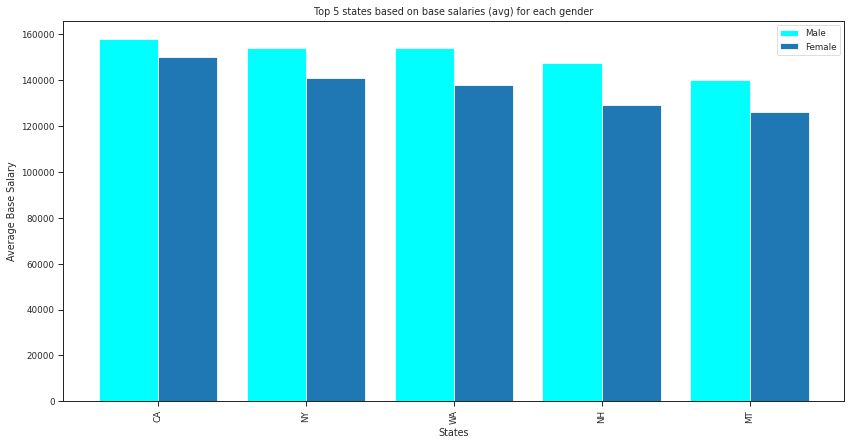

In [ ]:
# Plotting the bar chart of the data
x_axis = np.arange(len(top5_salary_by_gender[top5_salary_by_gender["gender"] == 'Female']["state"]))

plt.figure(figsize=(14, 7))
plt.bar(x_axis-0.2, top5_salary_by_gender[top5_salary_by_gender["gender"] == 'Male']["basesalary"], 0.4, label="Male", color='cyan')
plt.bar(x_axis + 0.2, top5_salary_by_gender[top5_salary_by_gender["gender"] == 'Female']["basesalary"], 0.4, label="Female")
plt.xticks(x_axis ,list(top5_salary_by_gender[top5_salary_by_gender["gender"] == 'Female']["state"]), rotation=90)
plt.xlabel("States")
plt.ylabel("Average Base Salary")
plt.title("Top 5 states based on base salaries (avg) for each gender")
plt.legend()
plt.show()

Question 12:

What are the top 5 states with bonus (avg) for each gender?

In [ ]:
p2 = df['bonus']
Lower_Fence,Upper_Fence = getBoxPlotFences(p2)
df_fil_bonus = df[(p2<=Upper_Fence) & (p2>Lower_Fence)]

fil_gen_by_bonus = df_fil_bonus[(df_fil_bonus['gender'] != "Unknown") & (df_fil_bonus['gender'] != "Other")]

avg_bonus_by_gender = fil_gen_by_bonus.groupby(["state", 'gender'], as_index=False)["bonus"].mean()

# Sorting the values in the decending order based on base salary.
sorted_avg_bonus_by_gender = avg_bonus_by_gender.sort_values(by="state", ascending=False)

# Getting top 5 salary by gender:
top5_bonus_by_gender = sorted_avg_bonus_by_gender.groupby('gender').head(5)

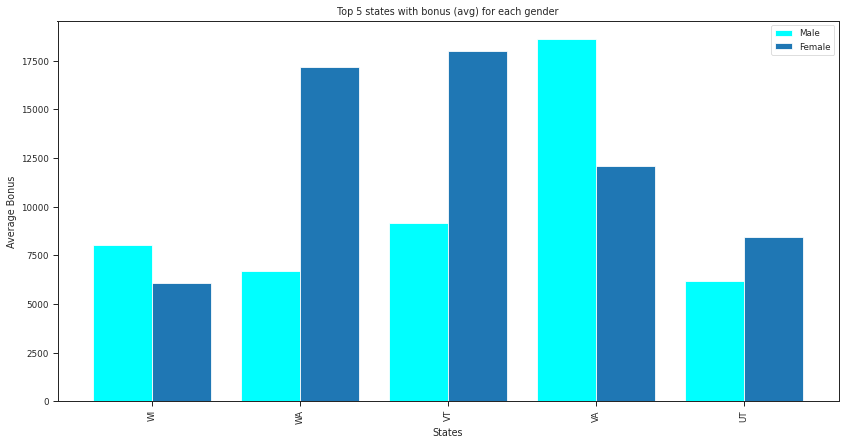

In [ ]:
male_bonus = top5_bonus_by_gender[top5_bonus_by_gender["gender"] == 'Male']["bonus"]
female_bonus = top5_bonus_by_gender[top5_bonus_by_gender["gender"] == 'Female']["bonus"]

X_axis = np.arange(len(top5_bonus_by_gender[top5_bonus_by_gender["gender"] == 'Female']["state"]))

plt.figure(figsize=(14, 7))
plt.bar(X_axis - 0.2, male_bonus , 0.4, label="Male", color='cyan')
plt.bar(X_axis + 0.2, female_bonus , 0.4, label="Female")
plt.xticks(X_axis ,list(top5_bonus_by_gender[top5_bonus_by_gender["gender"] == 'Female']["state"]), rotation=90)
plt.xlabel("States")
plt.ylabel("Average Bonus")
plt.title("Top 5 states with bonus (avg) for each gender")
plt.legend()
# plt.show()

Question 13:

What is the top degree level for the top 5 states based on salary (avg)?

Lower_Fence: 45000.0,Upper_Fence:253000.0


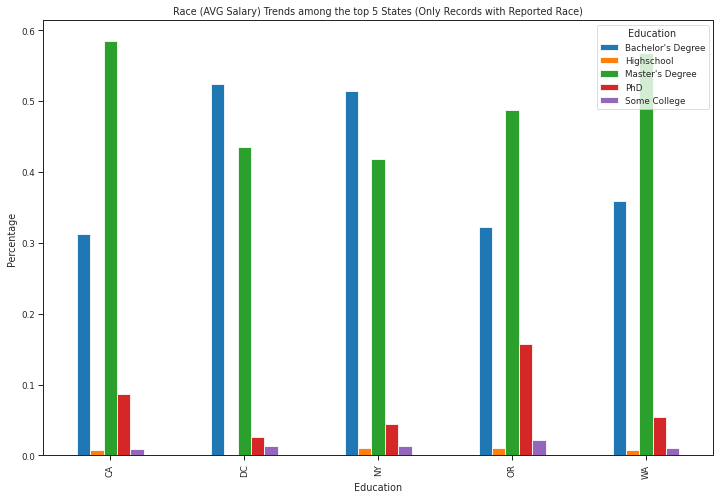

In [ ]:
cond_Unknow = df['Education'] != 'UnKnown'

res = df.loc[cond_Unknow,['state','Education','basesalary']]

Lower_Fence,Upper_Fence = getBoxPlotFences(res['basesalary'].copy())
print(f'Lower_Fence: {Lower_Fence},Upper_Fence:{Upper_Fence}')

res = res.copy()
res.loc[res['basesalary'] > Upper_Fence,'basesalary'] = Upper_Fence
res.loc[res['basesalary'] < Lower_Fence,'basesalary'] = Lower_Fence

#get valid states with >= 5 records
ValidStates = res.groupby('state').size()
ValidStates = ValidStates[ValidStates >= 5]
ValidStates = list(ValidStates.index)

cond_validStates = res['state'].apply(lambda x:x in ValidStates)
res = res[cond_validStates]

#get top 5 states bases on the avg of basesalary
top5_df = res.groupby('state').mean('basesalary').sort_values('basesalary',ascending=False)['basesalary'].head(5)
top5 = list(top5_df.index)

#set filters to get the top 5 states & to execlude 'UnKnown' Race (it does not make sense to be presented)
cond = res['state'].apply(lambda x:x in top5)

#get the results based on the filters
res = res.loc[cond,['state','Education']]
res = res.groupby(['state','Education']).size()
res = res / res.groupby('state').sum() # get percentage of each race

#Convert to DF
res_df = res.to_frame(name='cnt')

#Pivot DF
res_df = res_df.pivot_table('cnt',['state'],'Education')
res_df.reset_index(inplace=True)

#Plot
res_df.plot(x='state',y=list(res_df.columns).remove('state'),kind='bar',figsize=(12,8),
            title='Race (AVG Salary) Trends among the top 5 States (Only Records with Reported Race)',xlabel='Education',ylabel='Percentage')

Question 14:

What is the relation between gender and title (based on avg salary)?

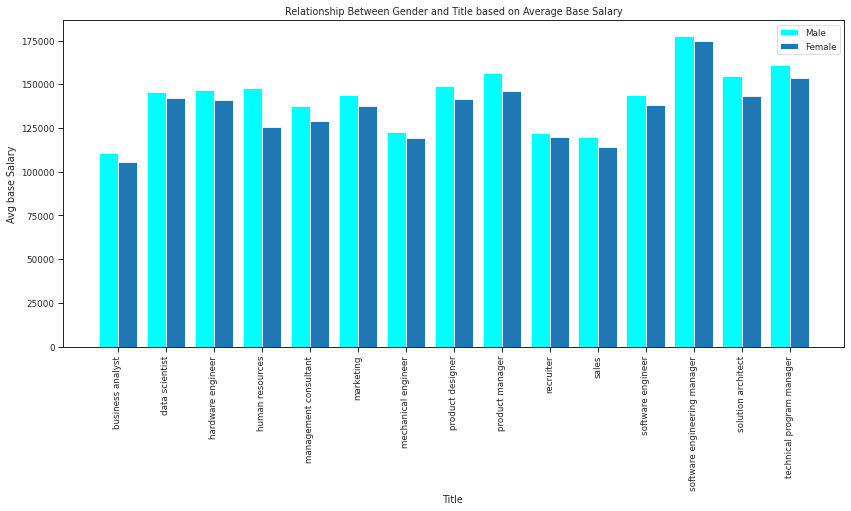

In [ ]:
gender_avg_sal_by_title = filtered_gender.groupby(['title','gender'], as_index=False).basesalary.mean()

gender_title = gender_avg_sal_by_title.groupby(['title']).head()

male = gender_title[gender_title["gender"] == 'Male']["basesalary"]
female = gender_title[gender_title["gender"] == 'Female']["basesalary"]

X_axis = np.arange(len(gender_title[gender_title["gender"] == 'Female']["title"]))

plt.figure(figsize=(14, 6))
plt.bar(X_axis - 0.2, male , 0.4, label="Male", color='cyan')
plt.bar(X_axis + 0.2, female , 0.4, label="Female")
plt.xticks(X_axis , list(gender_title[gender_title["gender"] == 'Female']["title"]) , rotation=90)
plt.title("Relationship Between Gender and Title based on Average Base Salary")
plt.xlabel("Title")
plt.ylabel("Avg base Salary")
plt.legend()
plt.show()

# Classification

# Predict Total totalyearlycompensation Range (Low,Mid,High)
## using SVM

In [ ]:
df1 = df.copy()
df1.drop(['timestamp','location', 'level', 'tag', 'otherdetails', 'cityid', 'dmaid', 'rowNumber', 'Masters_Degree', 'Bachelors_Degree',
         'Doctorate_Degree', 'Highschool', 'Some_College', 'Race_Asian', 'Race_White', 'Race_Two_Or_More', 'Race_Black',
         'Race_Hispanic' ], axis = 1, inplace= True)



In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

label_encoder = LabelEncoder()

#converting strings to numeric values
df1['gender'] = label_encoder.fit_transform(df1['gender'].values)
df1['title'] = label_encoder.fit_transform(df1['title'].values)
df1['Education'] = label_encoder.fit_transform(df1['Education'].values)
df1['Race'] = label_encoder.fit_transform(df1['Race'].values)
df1['city'] = label_encoder.fit_transform(df1['city'].values)
df1['state'] = label_encoder.fit_transform(df1['state'].values)
df1['company'] = label_encoder.fit_transform(df1['company'].values)



In [ ]:

df_classification1 = df1.copy()
df_classification1['basesalary'] = StandardScaler().fit_transform(df_classification1[['basesalary']])
df_classification1['stockgrantvalue'] = StandardScaler().fit_transform(df_classification1[['stockgrantvalue']])
df_classification1['bonus'] = StandardScaler().fit_transform(df_classification1[['bonus']])

#copy totalyearlycompensation column
df_classification1['totalyearlycompensation_numeric'] = df_classification1['totalyearlycompensation']
# categorize the totalyearlycompensation
df_classification1['totalyearlycompensation'] = pd.cut(df_classification1['totalyearlycompensation_numeric'], bins=[0, 155240, 305240, np.inf], include_lowest=True, labels=['low', 'mid', 'high'])


In [ ]:
listcol = list(df_classification1.columns)
listcol.remove('totalyearlycompensation_numeric')
df_classification1 = df_classification1[listcol]

listcol.remove('totalyearlycompensation')
X = df_classification1[ listcol].values

Y = df_classification1['totalyearlycompensation'].values

df_classification1

,company,title,totalyearlycompensation,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,bonus,gender,Race,Education,year,month,city,state
0,776,3,mid,8.0,1.0,-0.253232,-0.657084,0.239053,0,5,5,2020,7,375,3
1,455,11,low,1.0,1.0,-0.815949,-0.657084,-0.705586,3,4,5,2021,2,510,41
2,334,6,mid,10.0,10.0,0.759658,-0.546976,-0.705586,1,4,2,2019,11,256,41
3,793,11,mid,6.0,1.0,-0.009388,-0.326760,-0.233266,3,4,5,2021,5,525,3
4,627,11,high,8.0,0.0,4.135959,-0.450632,-0.705586,1,4,5,2019,4,315,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52833,594,11,mid,3.0,1.0,-0.365776,-0.524954,-0.296242,1,4,5,2020,2,471,45
52834,338,11,mid,1.0,1.0,-0.684648,-0.216653,1.656011,1,0,0,2020,9,339,3
52835,471,2,mid,5.0,5.0,-0.403290,-0.392825,-0.201779,1,0,3,2021,3,245,36
52836,404,8,high,5.0,1.0,0.103155,0.774318,0.239053,3,4,0,2020,12,375,3


In [ ]:
#implementation of Support Vector Machine
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics



X_train , X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2,random_state = 10,stratify = Y)

clf = SVC(C=1.0, kernel='linear', gamma = 'auto').fit(X_train, y_train)


In [ ]:
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9603520060560181


In [ ]:
for i in range(20):
  print(y_test[i],' | ',y_pred[i])

mid  |  mid
mid  |  mid
low  |  low
mid  |  mid
low  |  low
mid  |  mid
mid  |  mid
mid  |  mid
high  |  high
high  |  high
low  |  low
mid  |  mid
high  |  high
high  |  high
mid  |  mid
mid  |  mid
mid  |  mid
mid  |  mid
mid  |  mid
mid  |  mid


## Salary Value Prediction
### using LinearRegression

## Predict totalyearlycompensation

In [ ]:
df_classification2 = df1.copy()

In [ ]:

listcol = ['company','title','basesalary','bonus','state']
X = df_classification2[listcol].values
Y = df_classification2['totalyearlycompensation'].values

X.shape,Y.shape

((52838, 5), (52838,))

In [ ]:
df_classification2

,company,title,totalyearlycompensation,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,bonus,gender,Race,Education,year,month,city,state
0,672,8,137000,1.5,1.5,107000,20000,10000,3,4,5,2017,6,473,3
1,305,11,99999,5.0,3.0,72764,18480,8755,3,4,5,2017,6,513,3
2,42,8,309999,8.0,0.0,155000,105171,49828,3,4,5,2017,6,539,45
3,65,12,372000,7.0,5.0,157000,180000,35000,3,4,5,2017,6,574,3
4,594,11,156999,5.0,3.0,114239,29014,13746,3,4,5,2017,6,375,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52833,404,11,327000,10.0,1.0,155000,150000,22000,3,4,5,2018,9,539,45
52834,594,11,236999,2.0,2.0,146900,61135,28964,3,4,5,2018,9,471,45
52835,614,11,219999,14.0,12.0,157000,42747,20252,3,4,5,2018,9,539,45
52836,774,11,280688,8.0,4.0,194688,57000,29000,3,4,5,2018,9,513,3


In [ ]:
from sklearn.linear_model import LinearRegression

X_train , X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2,random_state = 10)

reg = LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1).fit(X_train, y_train)

print('score',reg.score(X_test, y_test))
print('')

score 0.6685719513556283



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


In [ ]:
from sklearn.metrics import explained_variance_score
#The explained_variance_score computes the explained variance regression score.
y_pred = reg.predict(X_test)
explained_variance_score(y_test, y_pred)


0.6686199469926408

In [ ]:
for i in range(20):
  print(y_test[i],' | ',round(y_pred[i]))


265000  |  304492
180000  |  179708
300000  |  411963
170000  |  234937
128000  |  163271
195000  |  234138
212000  |  249255
480000  |  451021
311999  |  295669
245000  |  262871
226000  |  178037
276000  |  290768
220000  |  238340
346000  |  320056
171000  |  170322
246000  |  231108
218000  |  207212
350000  |  409328
217000  |  193997
275000  |  282288
